<a href="https://colab.research.google.com/github/Zachary-Wenhao/IML-Team-Attack-Diffusion-Model/blob/data-preparation/Dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!pip install datasets
!pip install numpy
!pip install torch

In [84]:

import numpy as np
import torch
import random
from datasets import load_dataset
from PIL import Image


train = load_dataset("Maysee/tiny-imagenet", split="train")
val = load_dataset("Maysee/tiny-imagenet", split="valid")

print(train)
print(val)

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


In [85]:
# fish class has label 0, frog class has label 3

In [86]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset

class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, transform=None):
        """
        Args:
            huggingface_dataset: Our ImageNet dataset from huggingface
            transform: Potential transformation for the images
        """
        self.dataset = huggingface_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label


# Example transformation function: this is for use with Vision Transformers
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x), # apparently some images are not RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def tensor_to_pil_image(tensor):
  # Undo normalization
  unnormalize = transforms.Normalize(
      mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
      std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
  )
  tensor = unnormalize(tensor)  # Undo normalization
  tensor = tensor.clip(0, 1)  # Clip values to [0, 1] for valid image range
  tensor = tensor.permute(1, 2, 0)  # Rearrange dimensions to (H, W, C)
  return Image.fromarray((tensor.numpy() * 255).astype('uint8'))  # Convert to PIL

In [87]:
train_dataset = ImageNetDataset(train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataset = ImageNetDataset(val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

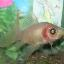

In [88]:
display(train['image'][0])

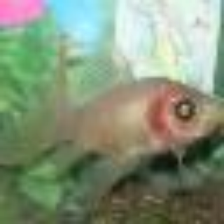

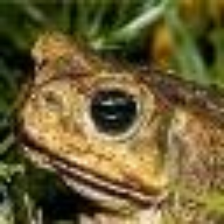

In [89]:
 # Retrieve the transformed image from the dataset
transformed_image, label = train_dataset.__getitem__(0)

# Convert the tensor back to a PIL image
image_to_display = tensor_to_pil_image(transformed_image)

# Display the image using PIL
display(image_to_display)

transformed_image, label = train_dataset.__getitem__(1500)
# Convert the tensor back to a PIL image
image_to_display = tensor_to_pil_image(transformed_image)

# Display the image using PIL
display(image_to_display)

In [90]:
display(train_dataset.__getitem__(0)[0])
print(type(train_dataset.__getitem__(0)[0]))
print(np.array(train_dataset.__getitem__(0)[0]).shape)

tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3481,  0.0398,  0.0398],
         ...,
         [-0.5596, -0.5596, -0.5596,  ..., -0.8164, -0.8335, -0.8335],
         [-0.5596, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849],
         [-0.5596, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849]],

        [[ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3102,  0.3102,  0.3102,  ...,  1.0980,  0.8004,  0.8004],
         ...,
         [ 0.0476,  0.0476,  0.0476,  ..., -0.8978, -0.9153, -0.9153],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678]],

        [[ 1.5594,  1.5594,  1.5594,  ...,  1.2980,  1.0017,  1.0017],
         [ 1.5594,  1.5594,  1.5594,  ...,  1

<class 'torch.Tensor'>
(3, 224, 224)


In [93]:
def attack(classifier, image, label, adv_image, steps, checkpoint):
  #assumes that classifier correctly classifies image at beginning
  '''classifier is pretrained imagenet classifier, image is clean input,
  adv_image is random image from other class, label is is correct label of image,
  steps is max # of swaps, checkpoint is check output every X steps
  This outputs the corrupted image'''

  #image_array = np.array(image)
  #adv_array = np.array(adv_image)
  #image = image.to(device)
  #adv_image = adv_image.to(device)
  channel, width, height = image.shape
  #every check_point swaps check if it classifies it correctly

  # Ensure inputs are 4D tensors
  image = image.unsqueeze(0)  # Add batch dimension
  adv_image = adv_image.unsqueeze(0)  # Add batch dimension

  channel, width, height = image.shape[1:]  # Exclude batch dimension
  print(image.shape, image.shape[1:])
  for i in range(steps):
    if i % checkpoint == 0:
      if classifier != None:
        with torch.no_grad():
          # Pass adv_image through the classifier
          prediction = classifier(adv_image)
          predicted_label = prediction.argmax(dim=1).item()
          if predicted_label != label:
              noised_image = adv_image
              print(f'Step {i}, we fooled the classifier: {predicted_label} != {label}')
              return noised_image.squeeze(0)  # Remove batch dimension
      else:
        pass
        #print(f'Step {i}, not yet fooled.')
    random_x = random.randint(0, height - 1)
    random_y = random.randint(0, width - 1)
    image[:, :, random_x, random_y] = (
        adv_image[:, :, random_x, random_y])
    #display(tensor_to_pil_image(image))

  #all steps done, not fooled
  #print(f'After {steps} steps, not fooled.')
  return image.squeeze(0)  # Return image without batch dimension



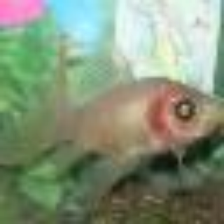

torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])


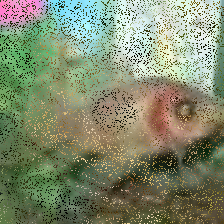

In [94]:
first_fish = train_dataset.__getitem__(0)[0]
display(tensor_to_pil_image(first_fish))
#print(type(first_fish)) torch tensor
#print(np.array(first_fish).shape) (3,224,224)
first_frog = train_dataset.__getitem__(1500)[0]
noised_image = attack(classifier=None, image=first_fish, label=0, adv_image=first_frog, steps=10000, checkpoint=500)
#print(type(noised_image))
#print(type(noised_image_tensor))
#print(noised_image_tensor.shape)
# Pass the tensor to the function
#noised_image = tensor_to_pil_image(noised_image_tensor)
display(tensor_to_pil_image(noised_image))

In [95]:
from torchvision import models

# Load in pre-trained model
model_path = 'fine_tune_classifier.pth'
model = models.efficientnet_b0(weights="IMAGENET1K_V1")  # Use weights instead of pretrained

# Fix classifier to match pretrained model's layer
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 200)
# Load  fine-tuned weights
state_dict = torch.load('fine_tune_classifier.pth', weights_only=True)

# Load the weights into the model
model.load_state_dict(state_dict)

model.eval()




EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [98]:
#import tqdm
from tqdm.notebook import tqdm  # Use tqdm notebook version for Jupyter

def get_random_image_from_class(dataset, target_class):
    indices = [i for i, (_, label) in enumerate(dataset) if label == target_class]
    random_idx = random.choice(indices)
    return dataset[random_idx][0]  # returns 3x224x224 image


def create_attack_dataset_direct(classifier, dataset, num_classes, attack_fn, **attack_kwargs):
    """
    Creates an attack dataset by applying the attack function directly on the dataset.

    Args:
        classifier: Pretrained model to attack.
        dataset: The dataset to process directly.
        num_classes: The total number of classes in the dataset.
        attack_fn: The attack function to apply to each image.
        attack_kwargs: Additional arguments for the attack function.

    Returns:
        attack_dataset: A list of tuples (corrupted_image, original_label).
    """
    if classifier is not None:
      classifier.eval()
    attack_dataset = []

    for idx in tqdm(range(len(dataset)), dynamic_ncols=True, leave=False, position=0):  # Iterate directly through the dataset indices
        image, label = dataset[idx]  # Access image and label directly

        # Determine the next class (class+1) with wrapping
        next_class = (label + 1) % num_classes

        # Get a random adversarial image from the next class
        adv_image = get_random_image_from_class(dataset, next_class)

        # Perform attack using the provided attack function
        corrupted_image = attack_fn(
            classifier=classifier,
            image=image,
            label=label,
            adv_image=adv_image,
            **attack_kwargs
        )

        # Append the corrupted image and its label to the attack dataset
        attack_dataset.append((corrupted_image, label))

    return attack_dataset


In [99]:
device = next(model.parameters()).device

train_attack_dataset = create_attack_dataset_direct(
    classifier=None,
    dataset=train_dataset,
    num_classes=200,
    attack_fn=attack,
    steps=12544,
    checkpoint=1000
)

  0%|          | 0/100000 [00:00<?, ?it/s]

torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])


KeyboardInterrupt: 

In [101]:
def create_attack_dataset_direct(classifier, dataset, num_classes, attack_fn, steps, checkpoint):
    """
    Creates an attack dataset by applying the attack function directly on the dataset.

    Args:
        classifier: Pretrained model to attack.
        dataset: The dataset to process directly.
        num_classes: The total number of classes in the dataset.
        attack_fn: The attack function to apply to each image.
        steps: Max number of pixel swaps in the attack function.
        checkpoint: Number of steps after which to check if the classifier is fooled.

    Returns:
        attack_dataset: A list of tuples (corrupted_image, original_label).
    """
    if classifier is not None:
        classifier.eval()

    attack_dataset = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if classifier is not None:
        classifier.to(device)

    # Precompute the first image of each class for faster access
    first_image_by_class = {}
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        if label not in first_image_by_class:
            first_image_by_class[label] = image
        # Stop if we've gathered all classes
        if len(first_image_by_class) == num_classes:
            break

    for label, image in tqdm(first_image_by_class.items(), dynamic_ncols=True, leave=False, position=0):
        # Get the adversarial image from the next class
        next_class = (label + 1) % num_classes
        adv_image = first_image_by_class[next_class]

        # Ensure tensors are on the correct device
        image = image.to(device)
        adv_image = adv_image.to(device)

        # Perform the attack
        corrupted_image = attack_fn(
            classifier=classifier,
            image=image,
            label=label,
            adv_image=adv_image,
            steps=steps,
            checkpoint=checkpoint
        )

        # Append to attack dataset
        attack_dataset.append((corrupted_image, label))

    return attack_dataset



In [102]:

train_attack_dataset = create_attack_dataset_direct(
    classifier=None,
    dataset=train_dataset,
    num_classes=200,
    attack_fn=attack,
    steps=12544,
    checkpoint=1000
)

  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size

In [104]:
print(train_attack_dataset[0])

(tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3652, -1.2788,  0.0569],
         [ 2.2489,  1.3070,  2.2489,  ...,  0.3481,  0.0398,  0.0398],
         ...,
         [-0.2513, -0.2513, -0.5596,  ..., -0.8164, -0.8335, -0.8335],
         [-0.3369, -0.5596, -0.3198,  ..., -1.5528, -0.8849, -0.8849],
         [-0.3369, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849]],

        [[ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3452,  0.3452,  0.3452,  ...,  1.1155, -1.1779,  0.8179],
         [ 0.3102,  1.4832,  0.3102,  ...,  1.0980,  0.8004,  0.8004],
         ...,
         [-0.1275, -0.1275,  0.0476,  ..., -0.8978, -0.9153, -0.9153],
         [-0.2150,  0.0476, -0.1975,  ..., -1.5805, -0.9678, -0.9678],
         [-0.2150,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678]],

        [[ 1.5594,  1.5594,  1.5594,  ...,  1.2980,  1.0017,  1.0017],
         [ 1.5594,  1.5594,  1.5594,  ...,  

In [105]:

val_attack_dataset = create_attack_dataset_direct(
    classifier=None,
    dataset=val_dataset,
    num_classes=200,
    attack_fn=attack,
    steps=12544,
    checkpoint=1000
)

  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
torch.Size

In [106]:
import pickle
def save_attack_dataset(attack_dataset, filename):
    # Move all tensors to CPU
    cpu_dataset = [(image.to('cpu'), label) for image, label in attack_dataset]

    # Save the dataset
    with open(filename, 'wb') as f:
        pickle.dump(cpu_dataset, f)

# Save the dataset to a file
save_attack_dataset(train_attack_dataset, "train_swap_attack_dataset.pkl")
save_attack_dataset(val_attack_dataset, "val_swap_attack_dataset.pkl")

In [109]:
def load_attack_dataset(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load the dataset
loaded_attack_dataset = load_attack_dataset("train_swap_attack_dataset.pkl")
loaded_attack_dataset_val = load_attack_dataset("val_swap_attack_dataset.pkl")

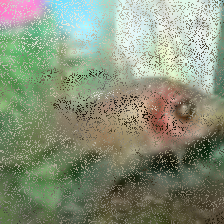

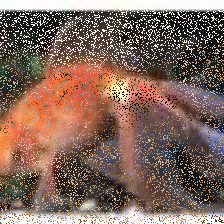

In [114]:
display(tensor_to_pil_image(loaded_attack_dataset[0][0]))
display(tensor_to_pil_image(loaded_attack_dataset_val[0][0]))